In [166]:
import cmath
import numpy as np
from tqdm import tqdm
import torch as t
import matplotlib.pyplot as plt
from library.plots import plot_surface
import pandas as pd

# use style from seaborn
plt.style.use('seaborn')
plt.rcParams['figure.dpi'] = 200

/var/folders/h9/1sb3bgkx6hb79gbgw7tgt0080000gn/T/ipykernel_47615/3817401536.py:10: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



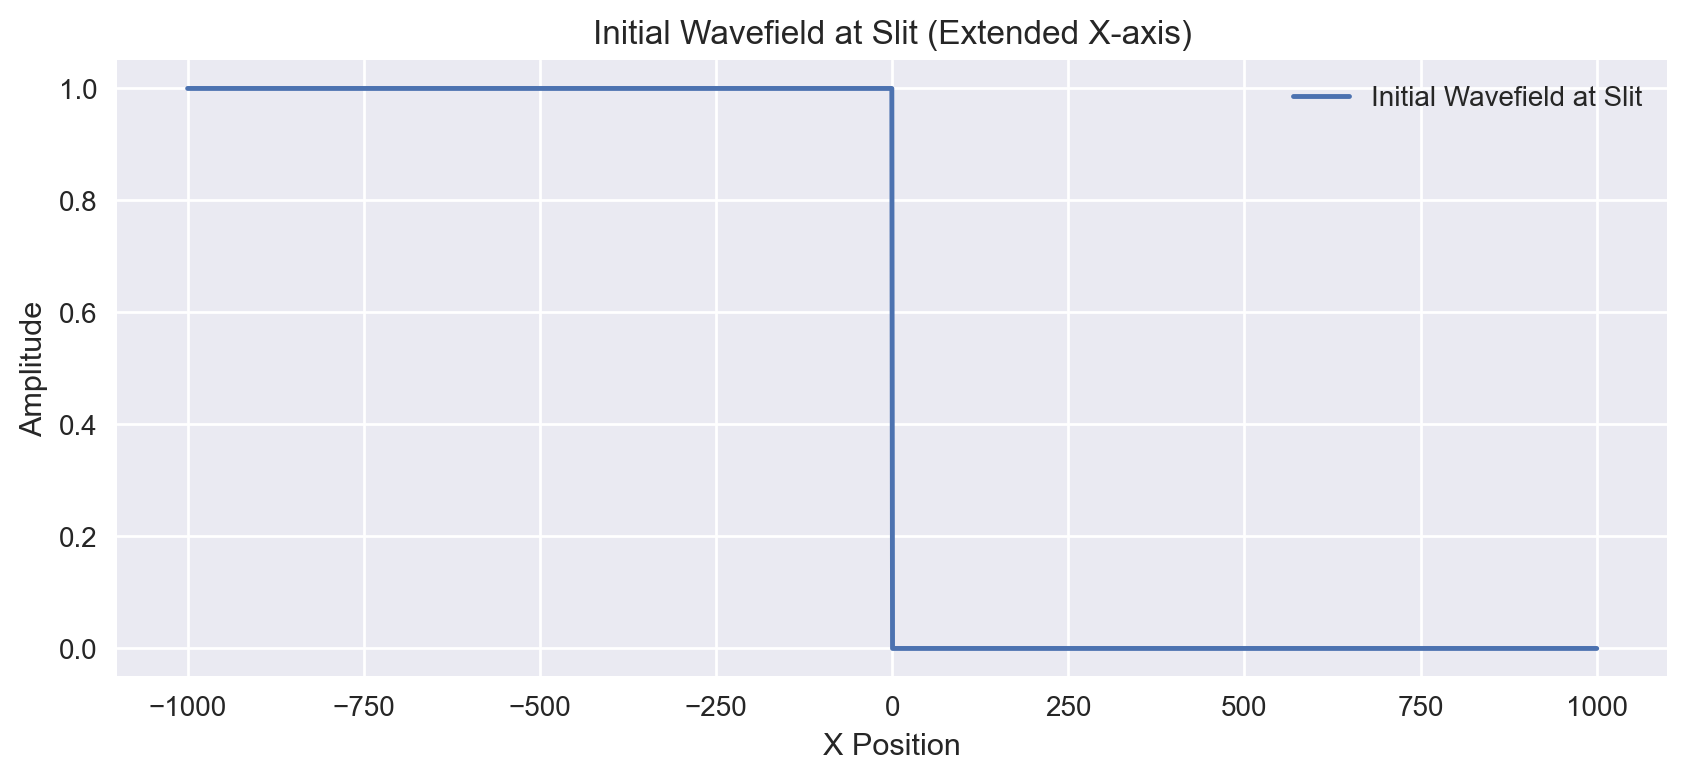

In [355]:
# Define parameters to mimic the setup of the Newtonian gravity experiment but with a 10x smaller slit
slit_width = 0  # From -10 to 10
wavelength = 0.06238
y_steps = np.linspace(1, 1000, 100)  # Screens at y=1 to y=1000

x_values_extended = np.linspace(-1000, 1000, 2000)

# Update the initial wavefield with the new x-axis range
initial_wavefield_extended = np.ones_like(x_values_extended)
# initial_wavefield_extended[np.abs(x_values_extended) > slit_width / 2] = 0
initial_wavefield_extended[x_values_extended > slit_width / 2] = 0

# Plot the updated initial wavefield at the slit
plt.figure(figsize=(10, 4))
plt.plot(x_values_extended, initial_wavefield_extended, label='Initial Wavefield at Slit')
plt.xlabel('X Position')
plt.ylabel('Amplitude')
plt.title('Initial Wavefield at Slit (Extended X-axis)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Function to implement the Rayleigh-Sommerfeld propagation algorithm
def rayleigh_sommerfeld_propagation(initial_wavefield, x_values, y, wavelength):
    dx = x_values[1] - x_values[0]  # step size in x
    propagated_wavefield = np.zeros_like(initial_wavefield, dtype=complex)

    for i, x in tqdm(enumerate(x_values)):
        integral = 0
        for j, x_prime in enumerate(x_values):
            r = np.sqrt((x - x_prime) ** 2 + y**2)
            phase = cmath.exp(1j * 2 * np.pi / wavelength * r)
            integral += initial_wavefield[j] * phase / r * dx
        propagated_wavefield[i] = integral * y / (1j * wavelength)

    return np.abs(propagated_wavefield) ** 2  # return intensity


# Initialize an array to store the wavefield at each screen (y position)
wavefield_3D = []

# Calculate the wavefield at each y step
for y in tqdm(y_steps):
    propagated_wavefield = rayleigh_sommerfeld_propagation(
        initial_wavefield_extended, x_values_extended, y, wavelength
    )
    wavefield_3D.append(propagated_wavefield)

# Convert to a NumPy array for easier manipulation
wavefield_3D = np.array(wavefield_3D)

2000it [00:05, 358.96it/s]


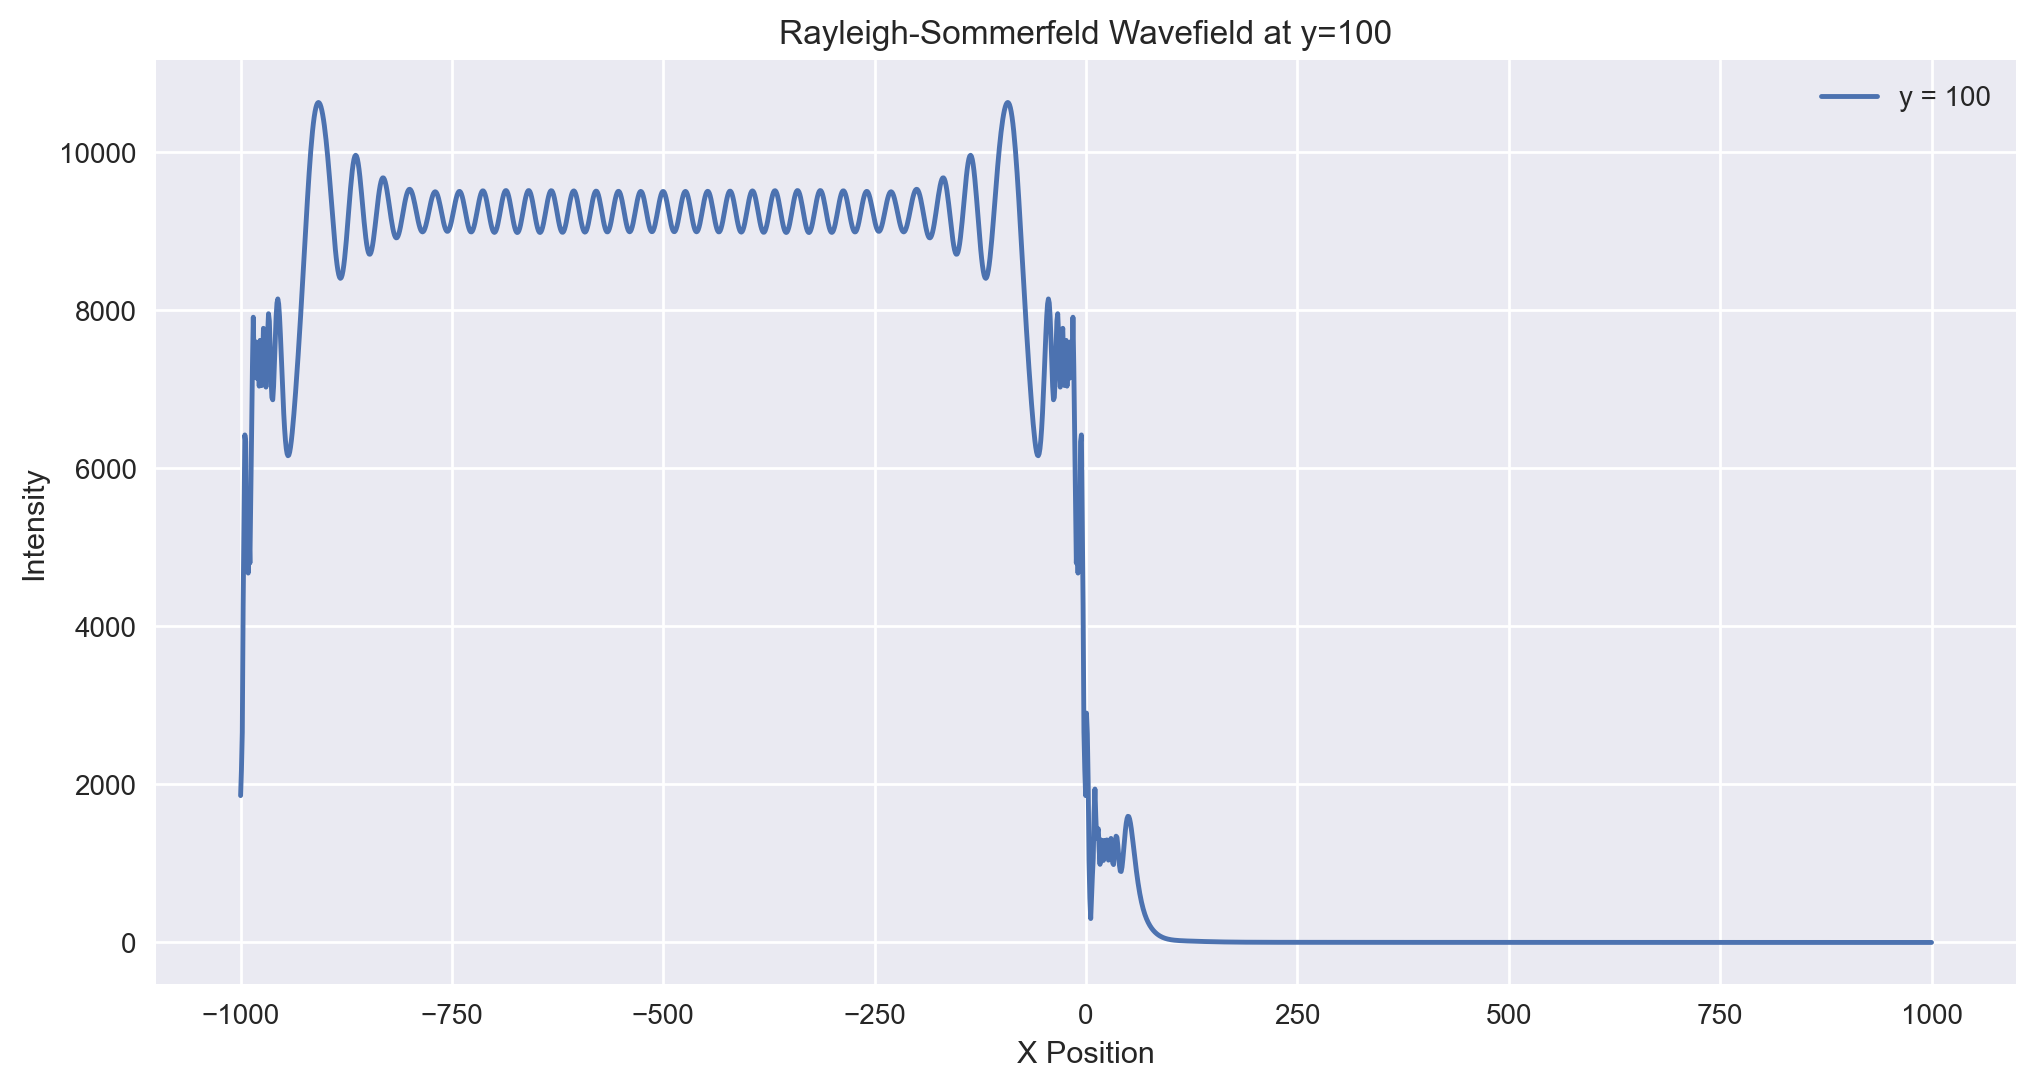

In [357]:
# Calculate the wavefield at y=100 using the Rayleigh-Sommerfeld model
wavefield_y100_RS = rayleigh_sommerfeld_propagation(initial_wavefield_extended, x_values_extended, 5, wavelength)

# Plot the wavefield at y=100 using the Rayleigh-Sommerfeld model
plt.figure(figsize=(12, 6))
plt.plot(x_values_extended, wavefield_y100_RS, label=f'y = 100')
plt.xlabel('X Position')
plt.ylabel('Intensity')
plt.title('Rayleigh-Sommerfeld Wavefield at y=100')
plt.legend()
plt.show()


100%|██████████| 101/101 [00:35<00:00,  2.88it/s]


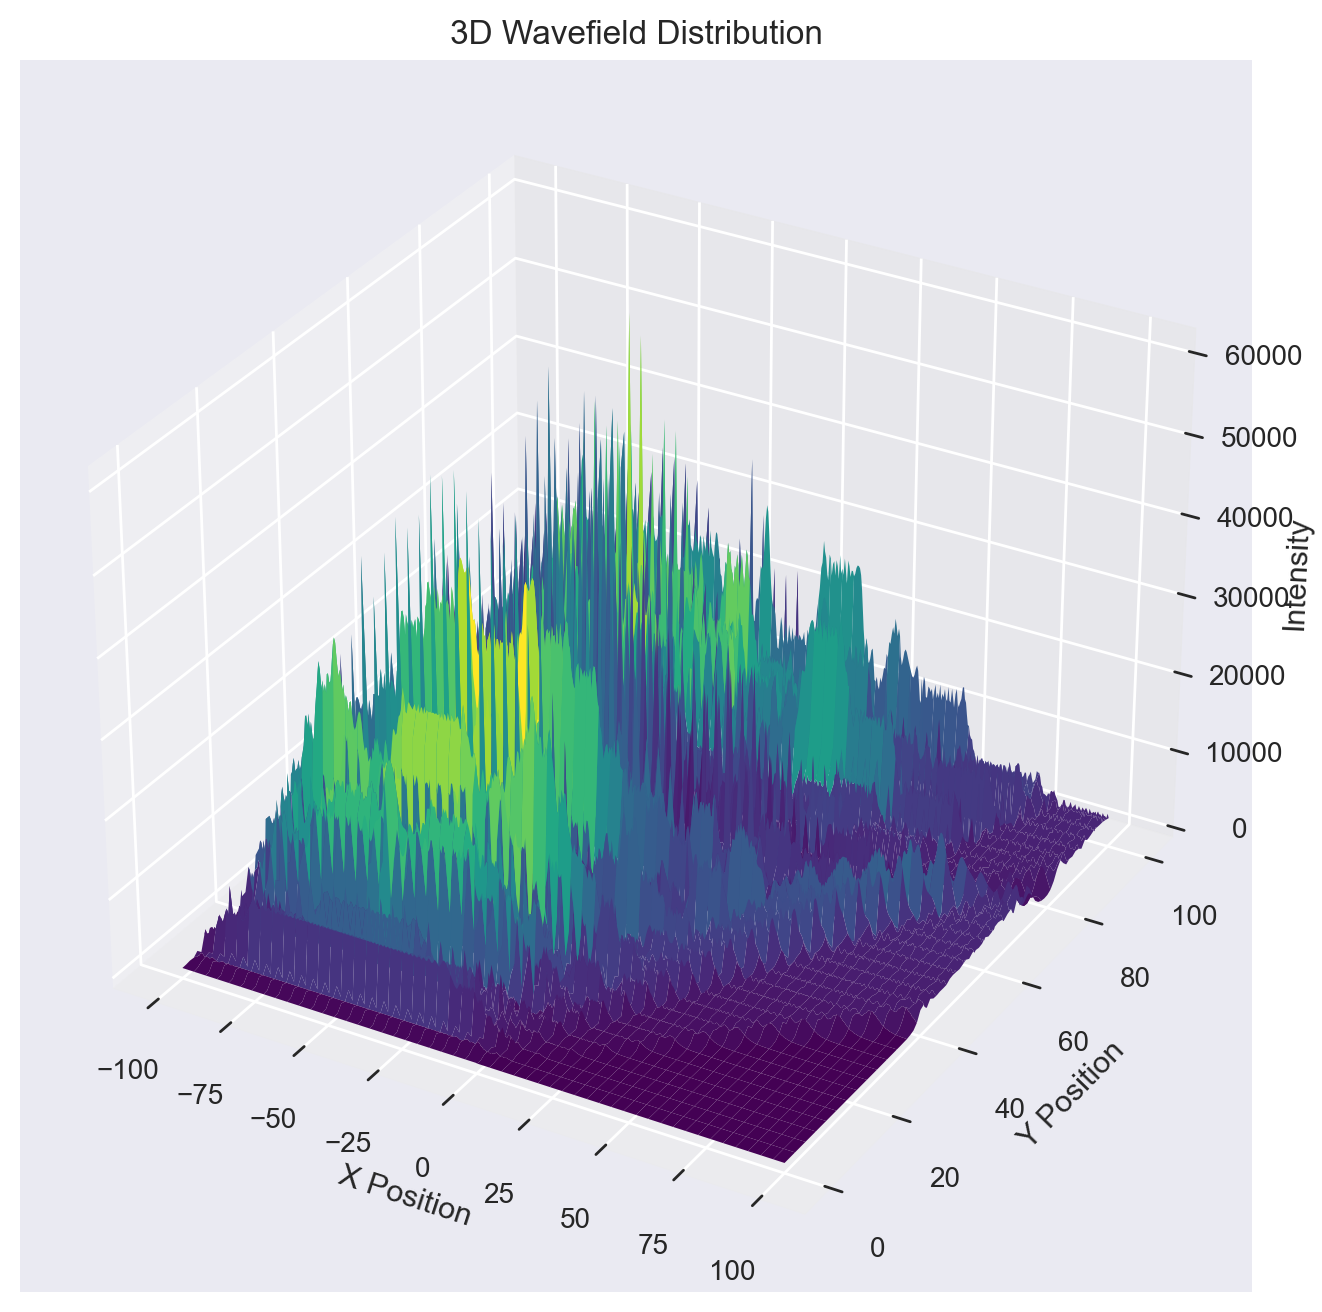

In [342]:
# Define a new range of y-values from 10 to 1000, in steps of 50
y_steps_long = np.arange(0.001, 101, 1)

# Initialize an array to store the wavefield at each screen (y position) for the longer range
wavefield_3D_long = []

# Calculate the wavefield at each y step in the longer range using the Rayleigh-Sommerfeld model
for y in tqdm(y_steps_long):
    propagated_wavefield = rayleigh_sommerfeld_propagation(initial_wavefield_extended, x_values_extended, y, wavelength)
    wavefield_3D_long.append(propagated_wavefield)

# Convert to a NumPy array for easier manipulation
wavefield_3D_long = np.array(wavefield_3D_long)

# Create a 3D plot for the calculated wavefield
from mpl_toolkits.mplot3d import Axes3D

X, Y = np.meshgrid(x_values_extended, y_steps_long)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, wavefield_3D_long, cmap='viridis')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Intensity')
ax.set_title('3D Wavefield Distribution')
plt.show()


# 2

In [243]:
def calculate_net_force(x, y, node_x, barrier_y, g, alpha, k, og_grav):
    """
    Calculate the net distorted gravitational force at a given point (x, y_coordinate)
    due to a gravitational node at (node_x, barrier_y).
    
    Parameters:
        x: float
            x-coordinate of the point where the force is being calculated.
        y_coordinate: float
            y-coordinate of the point where the force is being calculated.
        node_x: float
            x-coordinate of the gravitational node.
        barrier_y: float
            y-coordinate of the gravitational node.
        G: float
            Gravitational constant.
        alpha: float
            Amplitude of the wave-like distortion.
        k: float
            Wave number.
    
    Returns:
        net_force: ndarray
            The net distorted gravitational force at the point (x, y_coordinate).
    """
    distance_vector = np.array([node_x, barrier_y]) - np.array([x, y])
    distance_magnitude = np.linalg.norm(distance_vector)
    unit_vector = distance_vector / distance_magnitude
    force_mag = g / distance_magnitude ** 2
    force_mag = force_mag * (og_grav + alpha * np.sin(k * distance_magnitude))
    net_force = force_mag * unit_vector
    return net_force


In [252]:
# Initialize constants
G = 6.67430e-11  # Gravitational constant (m^3/kg/s^2)
G = 6e-10  # Gravitational constant (m^3/kg/s^2)
alpha = 1.0  # Amplitude of wave-like distortion
lambda_ = 0.001 # Wavelength (m)
og_grav = 0
k = 2 * np.pi / lambda_  # Wave number
time_step = 0.0001 # Time step for numerical integration (s)
total_time = 0.3  # Total simulation time (s)
num_steps = int(total_time / time_step)  # Number of time steps
epsilon = 0.0001  # Softening parameter for gravitational force (m)

# Update constants and initial conditions based on new requirements
x_range = 2.0
barrier_start_x1 = 0.25
barrier_end_x1 = 0.75
barrier_start_x2 = 1.25
barrier_end_x2 = 1.75
initial_velocity_magnitude = 300_000
particle_mass = 1e13


# Re-initialize particle positions and masses
# Initialize particle positions and masses
num_particles = 400

# Update particle positions based on new requirements
particle_start_x1 = barrier_start_x1 + epsilon
particle_end_x1 = barrier_end_x1 - epsilon
particle_start_x2 = barrier_start_x2 + epsilon
particle_end_x2 = barrier_end_x2  - epsilon

# Divide the number of particles equally between the two regions
num_particles1 = num_particles // 2
num_particles2 = num_particles // 2

# Initialize particle positions for the two regions
particle_positions1 = np.linspace(particle_start_x1, particle_end_x1, num_particles1).reshape(-1, 1)
particle_positions2 = np.linspace(particle_start_x2, particle_end_x2, num_particles2).reshape(-1, 1)

# Combine the positions and add the y-component (which is zero)
particle_positions1 = np.hstack([particle_positions1, np.zeros((num_particles1, 1))])
particle_positions2 = np.hstack([particle_positions2, np.zeros((num_particles2, 1))])
particle_positions = np.vstack([particle_positions1, particle_positions2])

# Initialize masses for the particles
particle_masses = np.ones(num_particles) * particle_mass

particle_positions[:5], particle_positions[-5:]  # Show some of the initial and final particle positions


# Re-initialize barrier
barrier_y = -0
barrier_nodes_x = np.array([barrier_start_x1, barrier_end_x1, barrier_start_x2, barrier_end_x2])

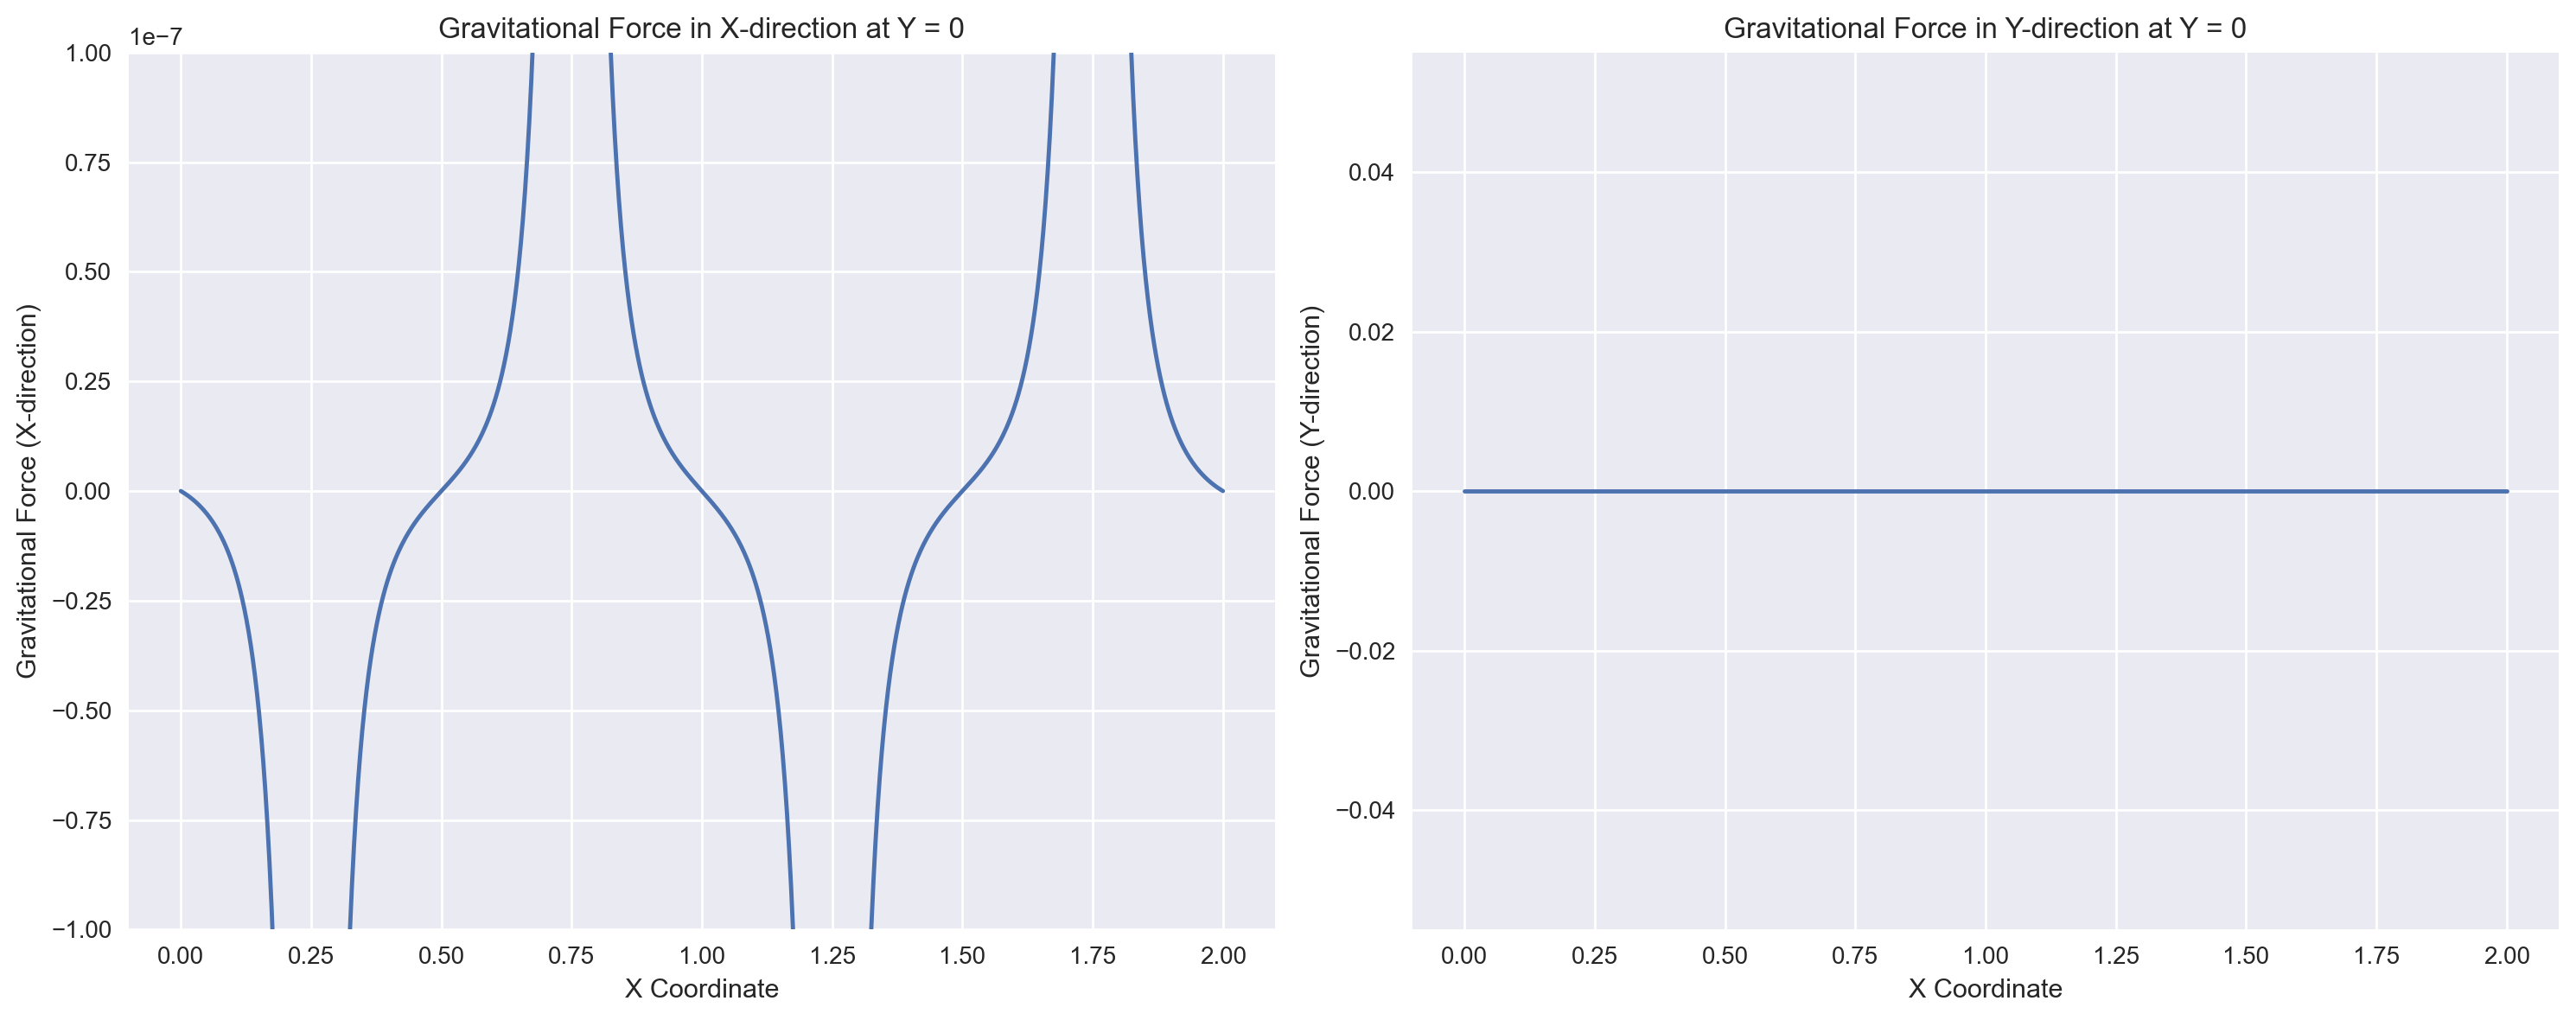

In [253]:
# Initialize the x-coordinates for which we want to calculate the gravitational force
x_coordinates_to_evaluate = np.linspace(0, 2, 1000)
y_coordinate = 0 # y-coordinate is set to 0

# Initialize an array to store the gravitational forces at each x-coordinate
gravitational_forces = np.zeros((len(x_coordinates_to_evaluate), 2))

# Calculate the distorted gravitational force at each x-coordinate
for i, x in enumerate(x_coordinates_to_evaluate):
    net_force = np.zeros(2)
    for node_x in barrier_nodes_x:
        # net_force += calculate_net_force(x, y, node_x, barrier_y, G, alpha, k)
        distance_vector = np.array([node_x, barrier_y]) - np.array([x, y_coordinate])
        distance_magnitude = np.linalg.norm(distance_vector)
        unit_vector = distance_vector / distance_magnitude
        force_mag = G / distance_magnitude**2
        force_mag = force_mag * (og_grav + alpha * np.sin(k * distance_magnitude))
        net_force += force_mag * unit_vector
    gravitational_forces[i] = net_force

# Plot the gravitational force in both x and y directions
plt.figure(figsize=(15, 6))

# Gravitational force in the x-direction
plt.subplot(1, 2, 1)
plt.plot(x_coordinates_to_evaluate, gravitational_forces[:, 0])
plt.xlabel('X Coordinate')
plt.ylabel('Gravitational Force (X-direction)')
plt.title(f'Gravitational Force in X-direction at Y = {y_coordinate}')
#limit y to y average
plt.ylim(-1e-7, 1e-7)
plt.grid(True)

# Gravitational force in the y-direction
plt.subplot(1, 2, 2)
plt.plot(x_coordinates_to_evaluate, gravitational_forces[:, 1])
plt.xlabel('X Coordinate')
plt.ylabel('Gravitational Force (Y-direction)')
plt.title(f'Gravitational Force in Y-direction at Y = {y_coordinate}')
plt.grid(True)

plt.tight_layout()
plt.show()


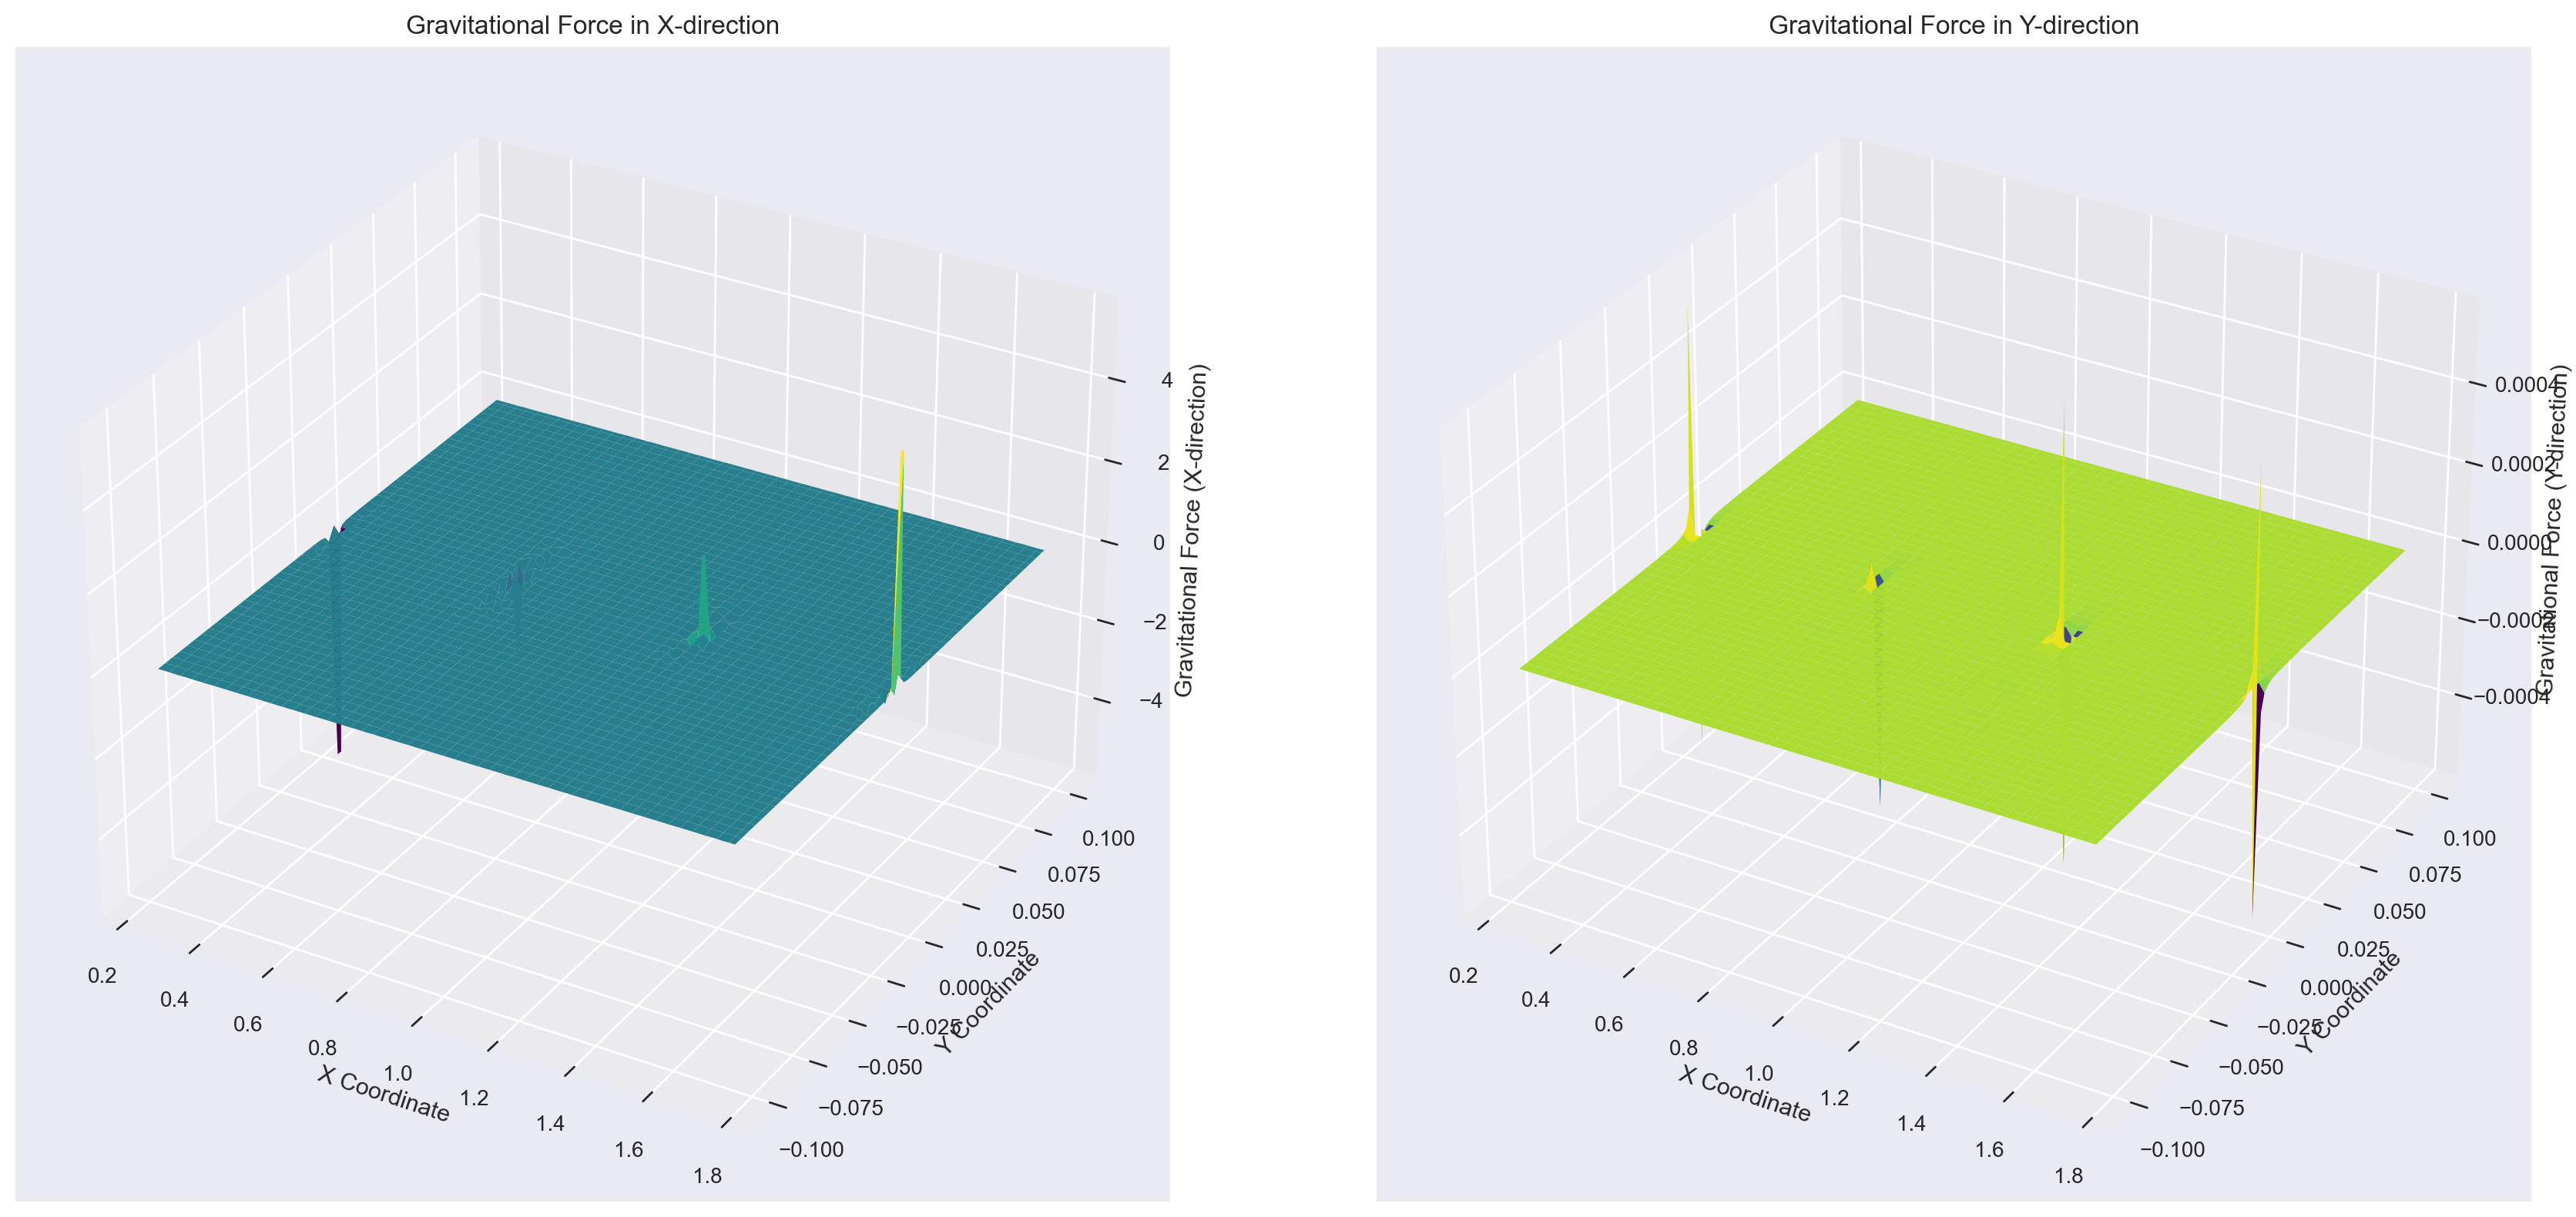

In [237]:
from mpl_toolkits.mplot3d import Axes3D

# Initialize the grid of x and y coordinates for which we want to calculate the gravitational force
x_grid, y_grid = np.meshgrid(np.linspace(particle_start_x, particle_end_x, 100), np.linspace(-0.1, 0.1, 100))

# Initialize arrays to store the gravitational forces at each point in the grid
gravitational_forces_x = np.zeros(x_grid.shape)
gravitational_forces_y = np.zeros(y_grid.shape)

# Calculate the distorted gravitational force at each point in the grid
for i in range(x_grid.shape[0]):
    for j in range(x_grid.shape[1]):
        x = x_grid[i, j]
        y = y_grid[i, j]
        net_force = np.zeros(2)
        for node_x in barrier_nodes_x:
            distance_vector = np.array([node_x, barrier_y]) - np.array([x, y])
            distance_magnitude = np.linalg.norm(distance_vector)
            unit_vector = distance_vector / distance_magnitude
            force_mag = G / distance_magnitude**2
            force_mag = force_mag * (og_grav+ alpha * np.cos(k * distance_magnitude))
            # distorted_force_magnitude = classical_force_magnitude
            net_force += force_mag * unit_vector
        gravitational_forces_x[i, j] = net_force[0]
        gravitational_forces_y[i, j] = net_force[1]

# Create the 3D plots
fig = plt.figure(figsize=(18, 8))

# 3D plot for gravitational force in the x-direction
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(x_grid, y_grid, gravitational_forces_x, cmap='viridis')
ax1.set_xlabel('X Coordinate')
ax1.set_ylabel('Y Coordinate')
ax1.set_zlabel('Gravitational Force (X-direction)')
ax1.set_title('Gravitational Force in X-direction')

# 3D plot for gravitational force in the y-direction
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(x_grid, y_grid, gravitational_forces_y, cmap='viridis')
ax2.set_xlabel('X Coordinate')
ax2.set_ylabel('Y Coordinate')
ax2.set_zlabel('Gravitational Force (Y-direction)')
ax2.set_title('Gravitational Force in Y-direction')

plt.tight_layout()
plt.show()


  0%|          | 0/2999 [00:00<?, ?it/s]

100%|██████████| 400/400 [00:00<00:00, 5497.73it/s]


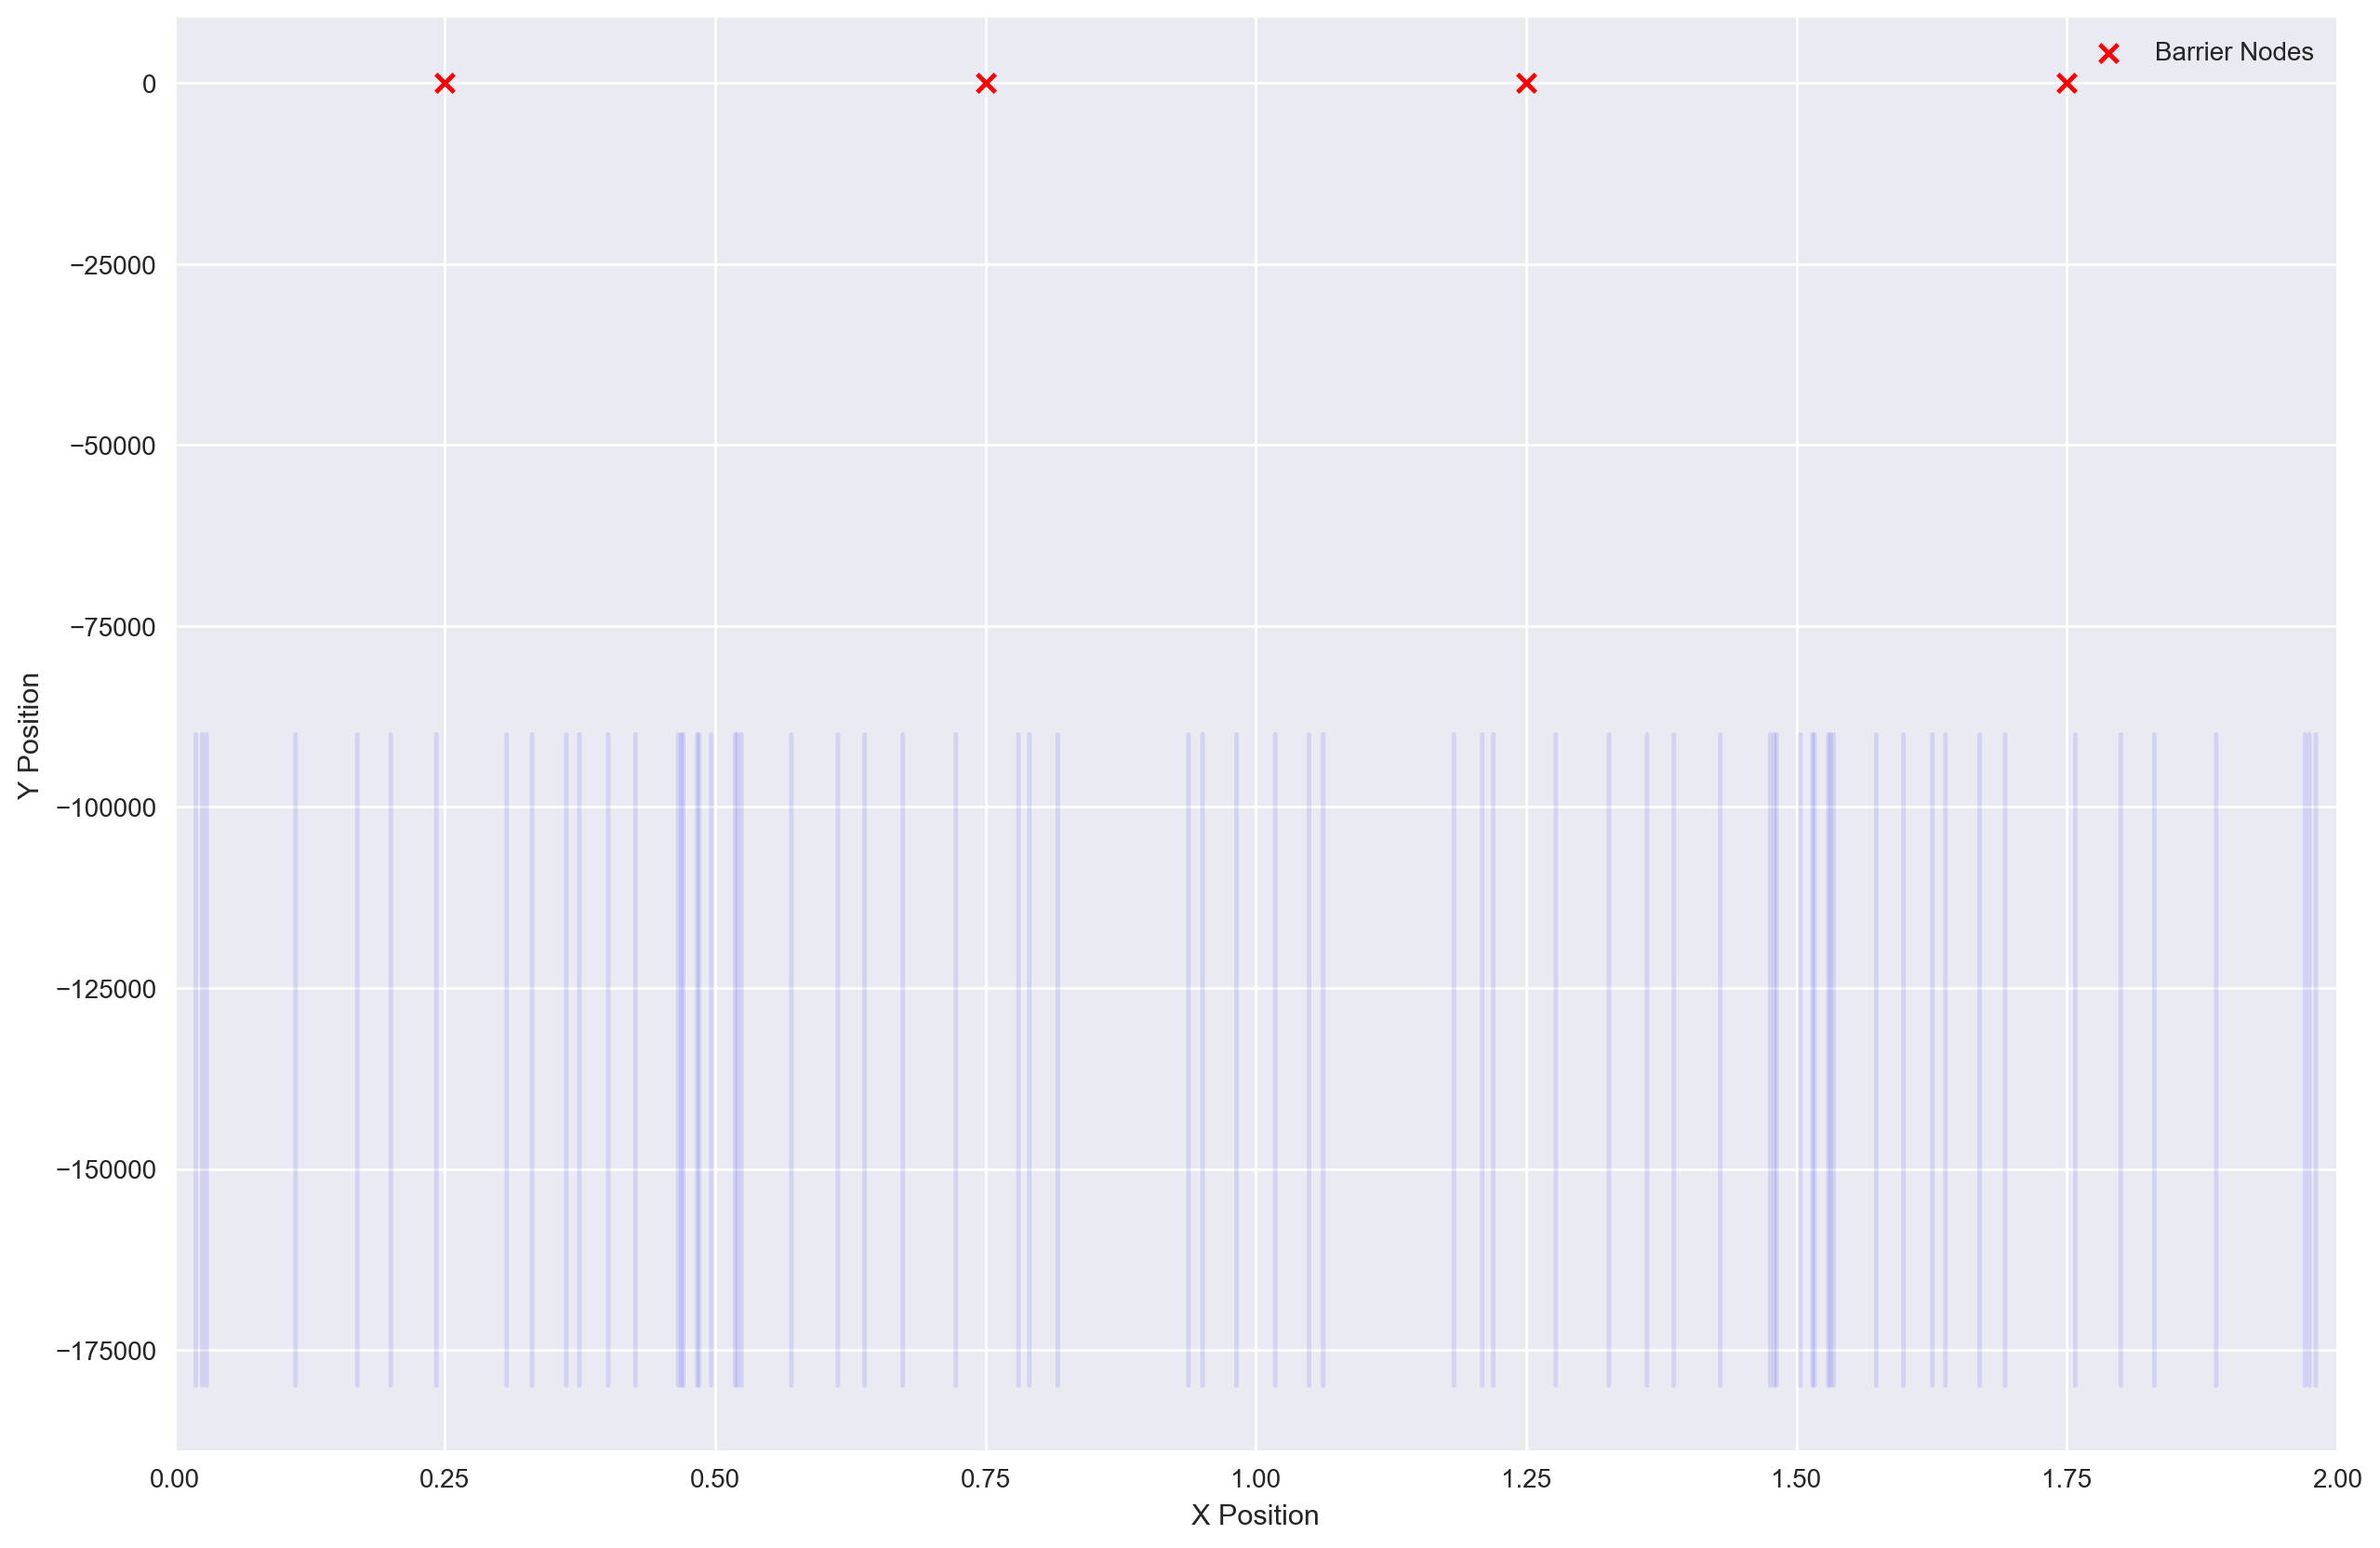

In [255]:
# Re-initialize velocity (all particles now have initial velocity directed towards the barrier)
particle_velocities = np.zeros((num_particles, 2))
particle_velocities[
    :, 1
] = -initial_velocity_magnitude  # Negative sign indicates motion towards the barrier
initial_velocities = particle_velocities.copy()

# Reset the particle positions history
particle_positions_history = [particle_positions.copy()]

# # Re-run the simulation loop
# for step in tqdm(range(num_steps)):
#     # Calculate distorted gravitational force on each particle
#     net_forces = np.zeros((num_particles, 2))
#     for i in range(num_particles):
#         for node_x in barrier_nodes_x:
#             distance_vector = np.array([node_x, barrier_y]) - particle_positions[i]
#             distance_magnitude = np.linalg.norm(distance_vector)
#             unit_vector = distance_vector / distance_magnitude
#             force_mag = G * particle_masses[i] / distance_magnitude**2
#             force_mag = force_mag * (og_grav + alpha * np.cos(k * distance_magnitude))
#             net_forces[i] += force_mag * unit_vector

#     # Update particle velocities and positions
#     particle_velocities += net_forces * time_step
#     max_velocity_magnitude = np.linalg.norm(initial_velocities, axis=1)
#     current_velocity_magnitude = np.linalg.norm(particle_velocities, axis=1)
#     scaling_factor = np.where(
#         current_velocity_magnitude > max_velocity_magnitude,
#         max_velocity_magnitude / current_velocity_magnitude,
#         1,
#     )
#     particle_velocities *= scaling_factor[:, np.newaxis]
#     particle_positions += particle_velocities * time_step

#     # Store the updated positions for visualization
#     particle_positions_history.append(particle_positions.copy())


# Re-run the simulation loop
particle_positions_history = [particle_positions.copy()]  # Reset history

for step in tqdm(range(num_steps)):
    net_forces = np.zeros((num_particles, 2))
    
    # Calculate distances from all particles to all nodes at once
    particle_positions_expanded = np.expand_dims(particle_positions, axis=1)
    barrier_nodes_expanded = np.expand_dims(np.array([barrier_nodes_x, [barrier_y]*len(barrier_nodes_x)]).T, axis=0)
    
    distance_vectors = barrier_nodes_expanded - particle_positions_expanded
    distance_magnitudes = np.linalg.norm(distance_vectors, axis=2)
    
    # Calculate unit vectors
    unit_vectors = distance_vectors / np.expand_dims(distance_magnitudes, axis=2)
    
    # Calculate distorted gravitational forces
    force_mags = G * particle_masses[:, np.newaxis] / distance_magnitudes**2
    force_mags *= (og_grav + alpha * np.cos(k * distance_magnitudes))
    net_forces = np.sum(force_mags[:, :, np.newaxis] * unit_vectors, axis=1)
    
    # Update particle velocities and positions
    particle_velocities += net_forces * time_step
    max_velocity_magnitude = np.linalg.norm(initial_velocities, axis=1)
    current_velocity_magnitude = np.linalg.norm(particle_velocities, axis=1)
    scaling_factor = np.where(
        current_velocity_magnitude > max_velocity_magnitude,
        max_velocity_magnitude / current_velocity_magnitude,
        1,
    )
    particle_velocities *= scaling_factor[:, np.newaxis]
    particle_positions += particle_velocities * time_step
    
    # Store the updated positions for visualization
    particle_positions_history.append(particle_positions.copy())


# Convert the history to a numpy array for easier indexing
particle_positions_history = np.array(particle_positions_history)

min_y = particle_positions_history[:, :, 1].min()
# Visualize the paths of particles
plt.figure(figsize=(15, 10))
for i in tqdm(range(num_particles)):
    plt.plot(
        particle_positions_history[:, i, 0],
        particle_positions_history[:, i, 1],
        color="blue",
        alpha=0.1,
    )
plt.scatter(
    barrier_nodes_x,
    np.full_like(barrier_nodes_x, barrier_y),
    c="red",
    marker="x",
    label="Barrier Nodes",
)
# limit x range to 0 to 2
plt.xlim(0, 2)
# plt.ylim(-10000, 2)
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
# plt.title("Paths of Particles Under Distorted Gravitational Force")
plt.grid(True)
plt.show()

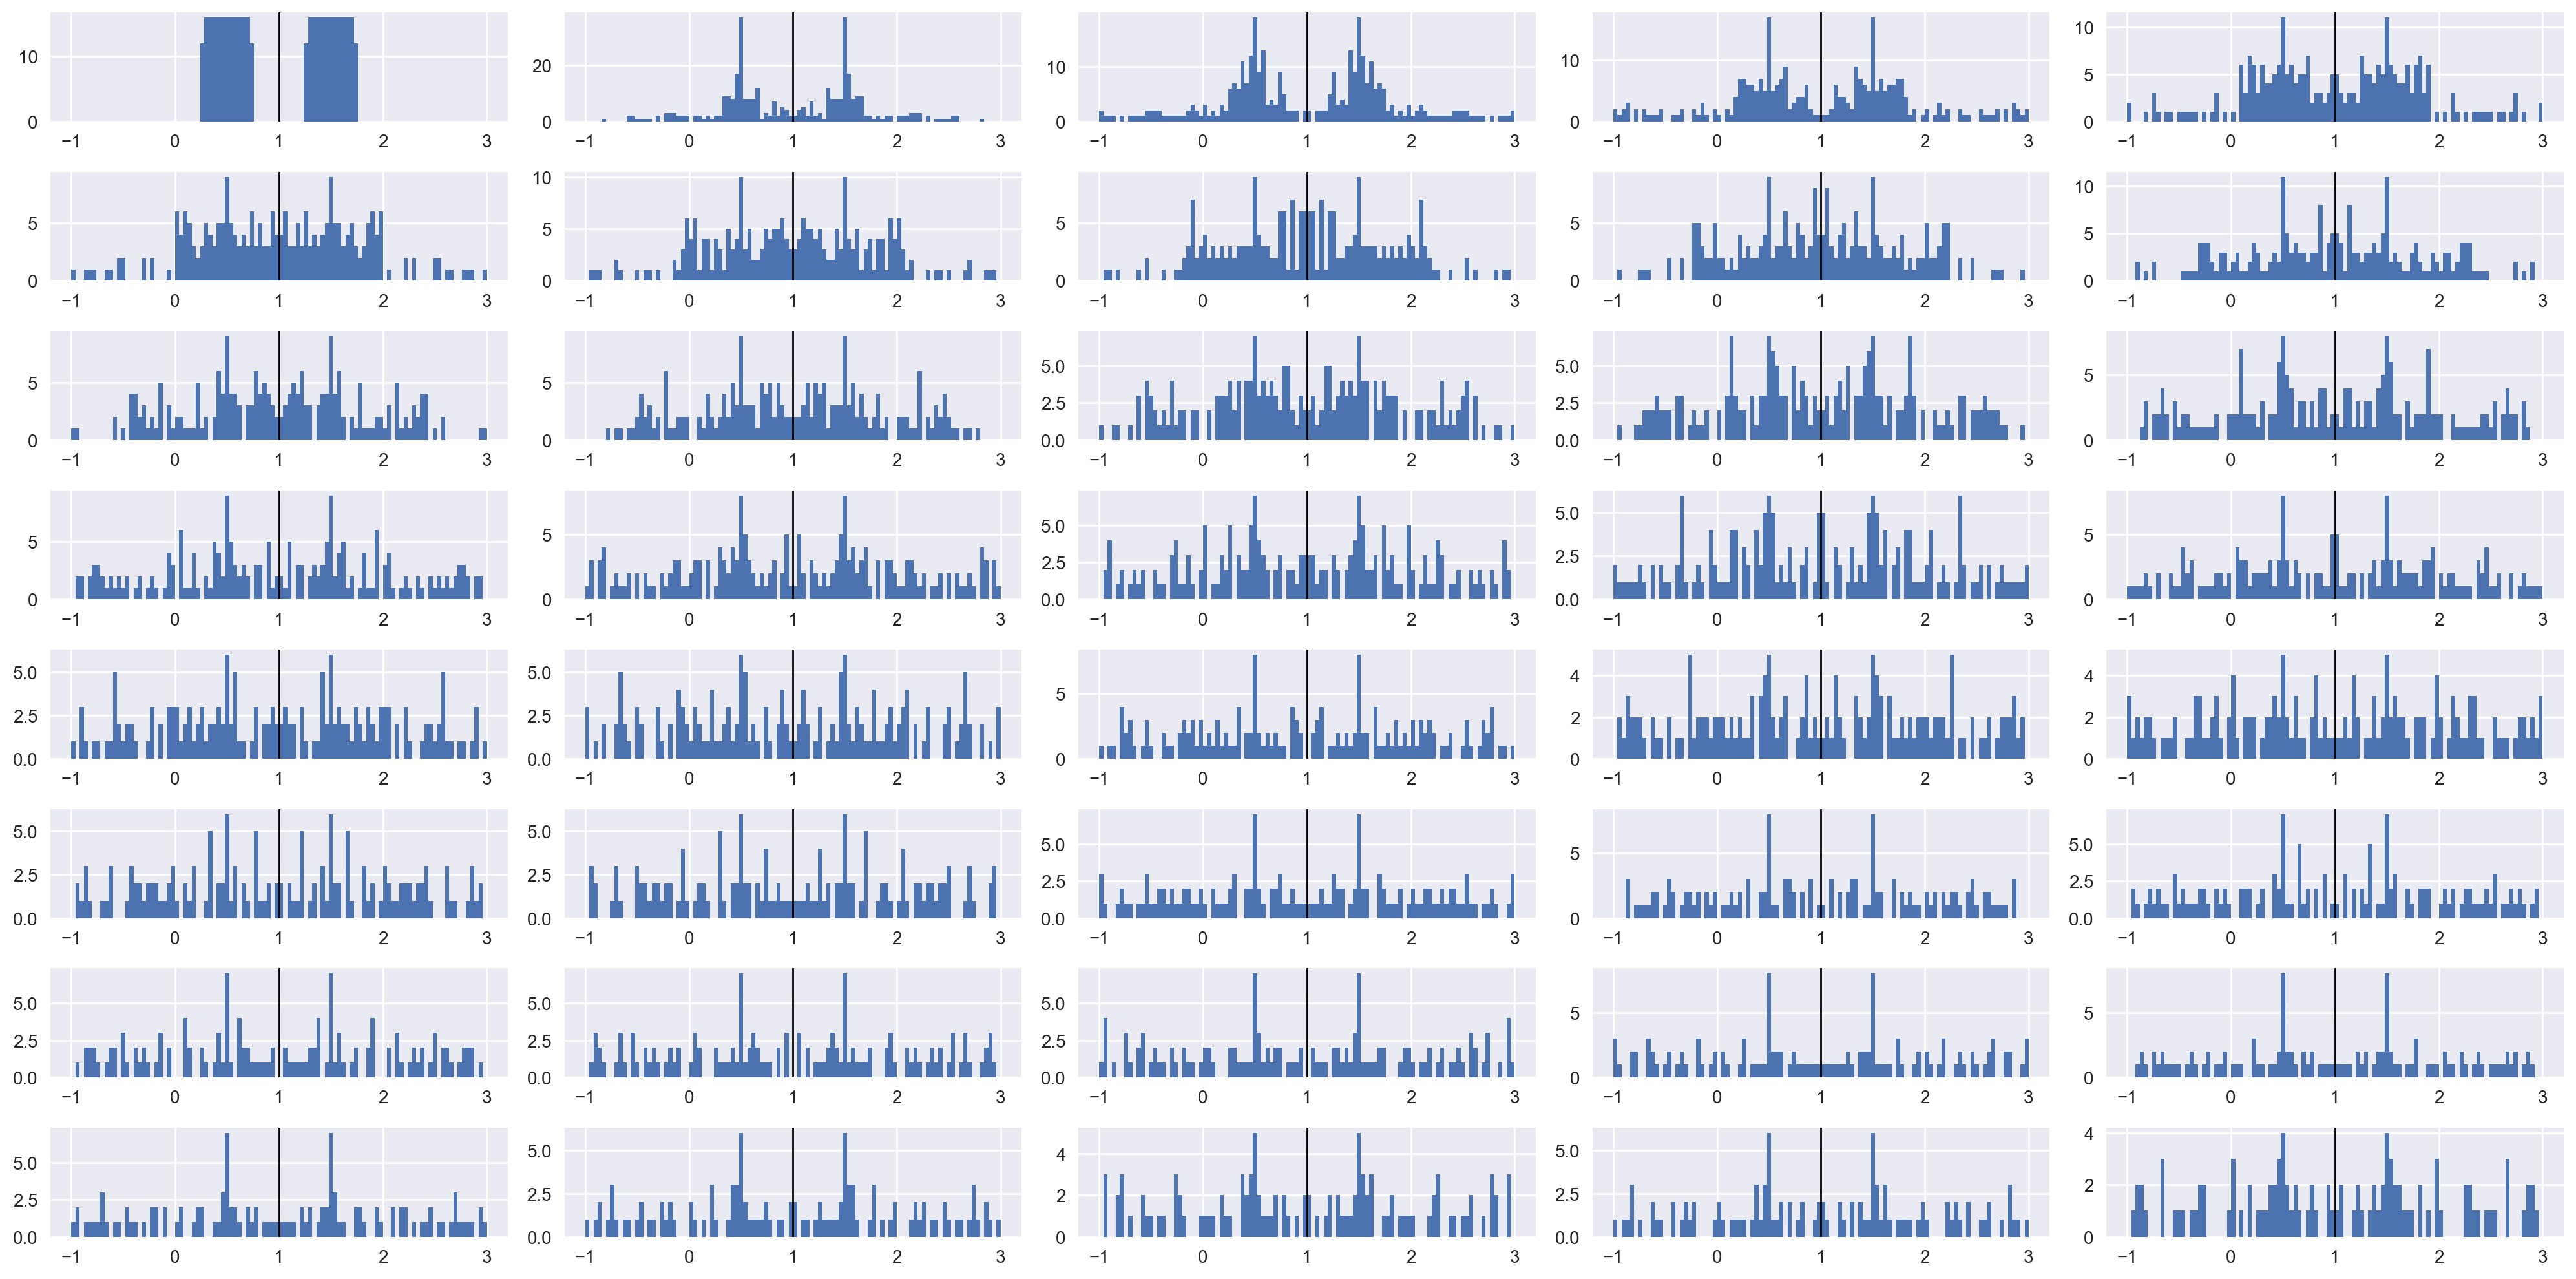

In [232]:
# Parameters
y_values = np.linspace(0, min_y, 40)

# Initialize the plot
fig, axes = plt.subplots(8, 5, figsize=(20, 10))
axes = axes.flatten()

# Loop over each subplot to plot the data for different y-values
for i, y in enumerate(y_values):
    ax = axes[i]
    
    # Find the closest y-position in the data
    closest_y_index = np.argmin(np.abs(particle_positions_history[:, :, 1] - y), axis=0)
    
    # Extract the corresponding x-positions
    x_positions_at_y = np.array([particle_positions_history[closest_y_index[j], j, 0] for j in range(num_particles)])
    
    # Plot the histogram
    ax.hist(x_positions_at_y, bins=100, density=False, range=(0-1, x_range+1), label=f'Y = {y}')
    ax.axvline(1, color='black', linewidth=1)
    # ax.set_xlabel('x')
    # ax.set_ylabel('Density')
    # hide legend
    ax.grid(True)

plt.tight_layout()
plt.show()


In [239]:
import plotly.graph_objects as go
import numpy as np

# Your existing particle_positions_history should be available here

# Define the bins for x and y coordinates
x_bins = np.linspace(0, 2, 50)
y_steps = np.linspace(0, min_y, 1000)  # steps from 0 to -300000

# Initialize 3D density array
density_3D = []

# Loop through each y_step to populate the density map
for y in y_steps:
    # Find closest y index for each particle at each time step
    closest_y_index = np.argmin(np.abs(particle_positions_history[:, :, 1] - y), axis=0)

    # Extract corresponding x-positions
    x_positions_at_y = np.array(
        [
            particle_positions_history[closest_y_index[i], i, 0]
            for i in range(num_particles)
        ]
    )

    # Calculate density at this y_step
    H, _ = np.histogram(x_positions_at_y, bins=x_bins, density=True)

    # Append density to 3D array
    density_3D.append(H)

# Convert the list to a numpy array
density_3D = np.array(density_3D)

# Create meshgrid for x and y_steps
x_mesh, y_mesh = np.meshgrid((x_bins[:-1] + x_bins[1:]) / 2, y_steps)

# # Create the 3D Plotly figure
# fig = go.Figure(
#     data=[
#         go.Surface(
#             z=density_3D,
#             x=x_mesh,
#             y=y_mesh,
#             reversescale=True,
#             colorscale="Turbo",
#             # colorscale=["black", "red"],
#             lighting=dict(diffuse=0.0, specular=0.0, fresnel=0.0, roughness=0.0),
#             # cmin=0,
#             # cmax=200,
#             contours_z=dict(
#                 project_x=False,
#                 project_y=False,
#                 project_z=False,
#                 highlight=True,
#                 highlightcolor="red",
#                 highlightwidth=1,
#             ),
#             contours_y=dict(
#                 highlightcolor="red",
#                 project_y=True,
#                 project_z=False,
#                 project_x=False,
#                 highlight=True,
#                 width=1,
#                 highlightwidth=1,
#                 show=False,
#             ),
#             contours_x=dict(
#                 highlightcolor="red",
#                 project_x=True,
#                 project_y=False,
#                 project_z=False,
#                 highlight=False,
#                 width=16,
#                 show=False,
#                 highlightwidth=1,
#             ),
#         )
#     ]
# )

# # Add axis labels and title
# fig.update_layout(
#     title="3D Density Map of Particle Positions",
#     scene=dict(
#         xaxis=dict(title="X Position"),
#         yaxis=dict(title="Y Position"),
#         zaxis=dict(title="Density"),
#     ),
# )
# fig.update_layout(
#     font=dict(size=8),
#     margin=dict(t=50, b=0, l=0, r=0),
# )
# # Show the plot
# fig.show(renderer="browser")

In [240]:
plot_surface(pd.DataFrame(density_3D), x_mesh, y_mesh, "plotly_dark", {})

In [ ]:
y = min_y  # The y-position of the screen
# Extract the particle positions at y = -3 or the closest to it
closest_y_index = np.argmin(np.abs(particle_positions_history[:, :, 1] - y), axis=0)

# Extract the corresponding x-positions
x_positions_at_y_minus_3 = np.array([particle_positions_history[closest_y_index[i], i, 0] for i in range(num_particles)])

# Plot the distribution of particle positions at y = -3
plt.figure(figsize=(10, 5))
# histogram bins equally spaced between 0 and x_range but with a line distribution instead of bar
plt.hist(x_positions_at_y_minus_3, bins=100, density=False, alpha=0.7, range=(0, x_range), label='Final Distribution of Particles')
# create vertical black line at x = 1
plt.axvline(1, color='black', linewidth=1)
plt.xlabel('x')
plt.ylabel('density')
# plt.title(f'Distribution of Particle Positions at Y = {y}')
plt.grid(True)
plt.show()
